__記号の定義__

Let $X_1,\ldots,X_n$ be a sample with size $n$ of a distribution with mean $\mu$ and variance $\sigma^2$ and set

$$
\begin{aligned}
&
\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i,
\\ &
S^2 = \frac{1}{n-1}\sum_{i=1}^n (X_i - \bar{X})^2,
\\ &
Z = \frac{\sqrt{n}(X - \mu)}{\sigma}
\quad (\text{expected to follow the standard normal distribution}),
\\ &
X^2 = \frac{(n-1)S^2}{\sigma^2} = \frac{1}{\sigma^2}\sum_{i=1}^n (X_i - \bar{X})^2
\quad (\text{expected to follow the chi-sauared distribution with df = $n-1$}),
\\ &
T = \frac{\sqrt{n}(X - \mu)}{S} = \frac{\sigma}{S}Z
\quad (\text{expected to follow the t-distribution with df = $n-1$}).
\end{aligned}
$$

Then $T^2$ is expected to follow the F-distribution with dfs = ($1$, $n-1$).

__プロット__

次の４つをプロットする:

1. $(Z, X^2)$ のサンプルの散布図
2. $X^2$ の値を決めたときの $Z$ の条件付き確率分布の密度函数 $p(z|x^2)$ のサンプルからの推定結果
3. $X^2$ の分布と自由度 $n-1$ のカイ二乗分布の比較
4. $T^2$ の分布と自由度 $(1, n-1)$ のF分布の比較

$T$ そのものの分布ではなく、その二乗の分布を見ることに注意。検定で使われるのは $T$ の絶対値だけなのであった。 

2におけるシアンの線はZの値の下位５％と上位95%の部分の境界である。推定値なので少しギザギザしてしまっている。

$Z$ と $X^2$ が確率変数として独立な場合にはシアンの線が縦軸に平行になる。

In [1]:
using Distributions
using StatsPlots
default(fmt=:png, titlefontsize=8, legendfontsize=7, guidefontsize=8, tickfontsize=6)
using Random
using KernelDensity
using QuadGK
using StatsBase

safediv(x, y) = y == 0 ? y : x/y

function myquantile(y, Y, Z, p; δ=log2(y)/4)
    mask = @. y - δ < Y < y + δ
    !any(mask) && return NaN
    quantile(Z[mask], p)
end

myskewness(dist) = skewness(dist)
myskewness(dist::MixtureModel) = _myskewness(dist)
function _myskewness(dist)
    μ, σ = mean(dist), std(dist)
    f(x) = ((x - μ)/σ)^3 * pdf(dist, x)
    quadgk(f, extrema(dist)...)[1]
end

mykurtosis(dist) = kurtosis(dist)
mykurtosis(dist::MixtureModel) = _mykurtosis(dist)
function _mykurtosis(dist)
    μ, σ = mean(dist), std(dist)
    f(x) = ((x - μ)/σ)^4 * pdf(dist, x)
    quadgk(f, extrema(dist)...)[1] - 3
end

rd(x; digits=4) = round(x; digits)

name(dist) = replace(string(dist), r"\{.*\}"=>"")
function name(dist::MixtureModel)
    c = components(dist)
    p = probs(dist)
    s = string(p[1]) * name(c[1])
    for i in 2:length(p)
        s = s * "+" * string(p[i]) * name(c[i])
    end
    s
end

function mcsim(;
        dist = Beta(0.2, 0.3),
        n = 20,
        L = 10^6,
    )
    μ, σ = mean(dist), std(dist)
    Z = Vector{Float64}(undef, L) # expected to follow Normal(1,0)
    X² = similar(Z)               # expected to follow Chisq(n-1)
    tmp = [Vector{Float64}(undef, n) for i in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        X = rand!(dist, tmp[Threads.threadid()])
        X̄ = mean(X) # sample mean
        S² = var(X) # sample unbiased variance
        Z[i] = √n * (X̄ - μ) / σ
        X²[i] = (n - 1) * S²/σ^2
    end
    T = @. Z / √(X²/(n - 1)) # expected to follow TDist(n-1)
    T² = @. T .^ 2           # expected to follow FDist(1, n-1)
    (; dist, n, Z, X², T, T²)
end

function plot_samplestats(;
        dist = Normal(1, 2),
        n = 10,
        L = 10^6,
        scattermax = 10^5,
        T²tail = 0.75,
        kwargs...
    )
    (; dist, n, Z, X², T, T²) = mcsim(; dist, n, L)
    distname = name(dist)
    sk = myskewness(dist)
    ku = mykurtosis(dist)
    fdist = FDist(1, n-1)
    
    println(L, " samples with size n = ", n, " of ", distname)
    println("skewness, kurtosis = ", rd(sk), ", ", rd(ku))
    for p in (0.95,)# 0.99)
        println("√quantile(T², $p) = ", rd(√quantile(T², p)), ",  ")
        println("P(|T| > √quantile(FDist(1, $(n-1)), $p) = ", rd(√quantile(fdist, p)), ") = ",  rd(1 - ecdf(T²)(quantile(fdist, p))))
    end
    
    X²lim = quantile.(Ref(X²), (0.001, 0.999))
    Zlim = quantile.(Ref(Z), (0.001, 0.999))
    
    kdeX² = InterpKDE(kde(X²))
    kdeZX² = InterpKDE(kde((Z, X²)))
    g(z, x²) = safediv(pdf(kdeZX², z, x²), pdf(kdeX², x²))
    kdeT² = InterpKDE(kde(T²))
    h(t²) = pdf(kdeT², t²)
    
    P = plot(; colorbar=false)
    plot!(; xlabel="Z = √n(X̄ - μ)/σ", ylabel="X² = (n - 1)S²/σ²", xlim=Zlim, ylim=X²lim)
    scatter!(Z[1:min(end, scattermax)], X²[1:min(end, scattermax)]; alpha=0.3, msw=0, ms=1, label="")
    vline!([0]; label="", ls=:dot, c=:red)
    hline!([n-1]; label="", ls=:dot, c=:red)
    title!("$distname, n=$n")
    
    z = range(Zlim..., 200)
    x² = range(X²lim..., 200)
    z05 = (x² -> myquantile(x², X², Z, 0.05)).(x²)
    z95 = (x² -> myquantile(x², X², Z, 0.95)).(x²)
    Q = plot(; colorbar=false)
    plot!(; xlabel="Z = √n(X̄ - μ)/σ conditioned by X²", ylabel="X² = (n - 1)S²/σ²", xlim=Zlim, ylim=X²lim)
    heatmap!(z, x², g)
    plot!(z05, x²; label="", c=:cyan)
    plot!(z95, x²; label="", c=:cyan)
    vline!([0]; label="", ls=:dot, c=:pink)
    hline!([n-1]; label="", ls=:dot, c=:pink)
    title!("p(z|x²)")
    
    chisqdist = Chisq(n-1)
    xlim = (max(0.0, quantile(X², 0.005) - 10), max(quantile(X², 0.995), quantile(chisqdist, 0.999)))
    R = plot(; xlabel="X² = (n - 1)S²/σ²", ylabel="density", xlim)
    histogram!(X²; norm=true, alpha=0.3, bin=range(xlim..., 100), label="X²")
    plot!(chisqdist, xlim...; label="Chisq($(n-1))", lw=1.5)
    vline!([n-1]; label="", ls=:dot, c=:black)
    title!("sample of X² = (n - 1)S²/σ²")
    
    xlim = quantile.(Ref(T²), (T²tail, 0.999))
    bin = range(0, last(xlim), round(Int, 100last(xlim)/(last(xlim) - first(xlim))))
    ymax = maximum(x -> max(pdf(fdist, x), h(x)), range(xlim..., 100))
    ylim = (-0.03ymax, 1.05ymax)
    S = plot(; xlabel="T² where T = √n(X̄ - μ)/S", ylabel="density", xlim, ylim)
    histogram!(T²; norm=true, alpha=0.3, bin=bin, label="T²")
    plot!(fdist, xlim...; label="FDist(1, $(n-1))", lw=1.5)
    vline!([quantile(T², 0.95)]; label="95% line of T²", c=1, ls=:dot)
    vline!([quantile(fdist, 0.95)]; label="95% line of FDist", c=2, ls=:dot)
    title!("tail (> $(100T²tail)%) of sample of T²")
    
    plot(P, Q, R, S; size=(800, 600))
    plot!(leftmargin=3Plots.mm, bottommargin=3Plots.mm, kwargs...)
end

plot_samplestats (generic function with 1 method)

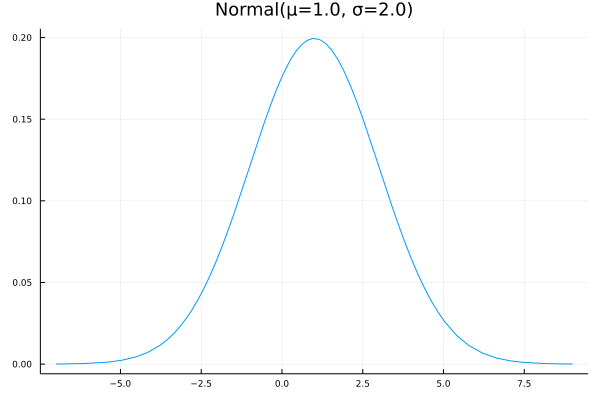

In [2]:
dist = Normal(1, 2); plot(dist, -7, 9; label="", title=name(dist), titlefontsize=12)

1000000 samples with size n = 10 of Normal(μ=1.0, σ=2.0)
skewness, kurtosis = 0.0, 0.0
√quantile(T², 0.95) = 2.2608,  
P(|T| > √quantile(FDist(1, 9), 0.95) = 2.2622) = 0.0499


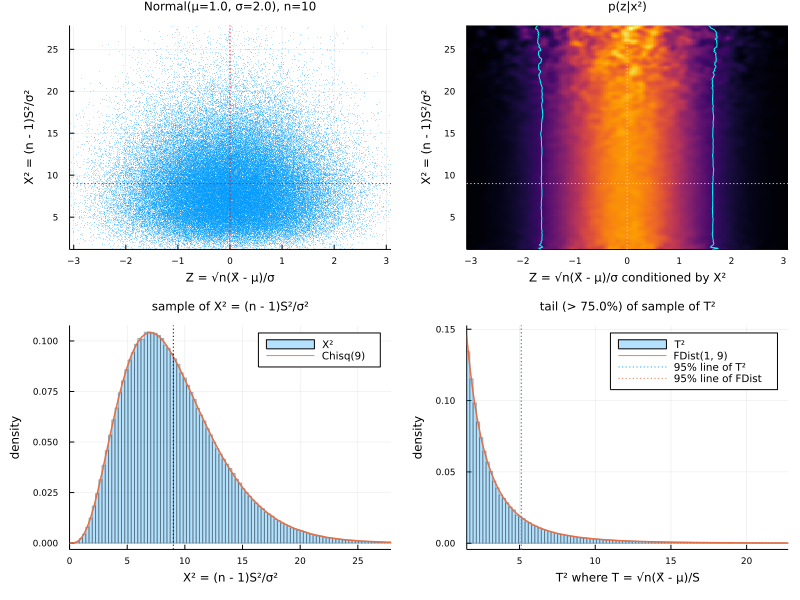

In [3]:
plot_samplestats(dist = Normal(1, 2), n = 10)

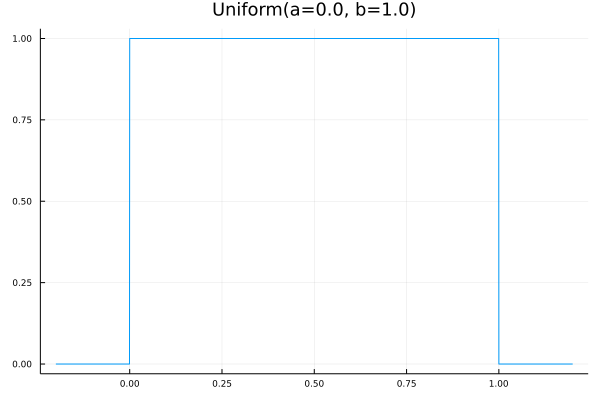

In [4]:
dist = Uniform(); plot(dist, -0.2, 1.2; label="", title=name(dist), titlefontsize=12)

1000000 samples with size n = 10 of Uniform(a=0.0, b=1.0)
skewness, kurtosis = 0.0, -1.2
√quantile(T², 0.95) = 2.3201,  
P(|T| > √quantile(FDist(1, 9), 0.95) = 2.2622) = 0.0543


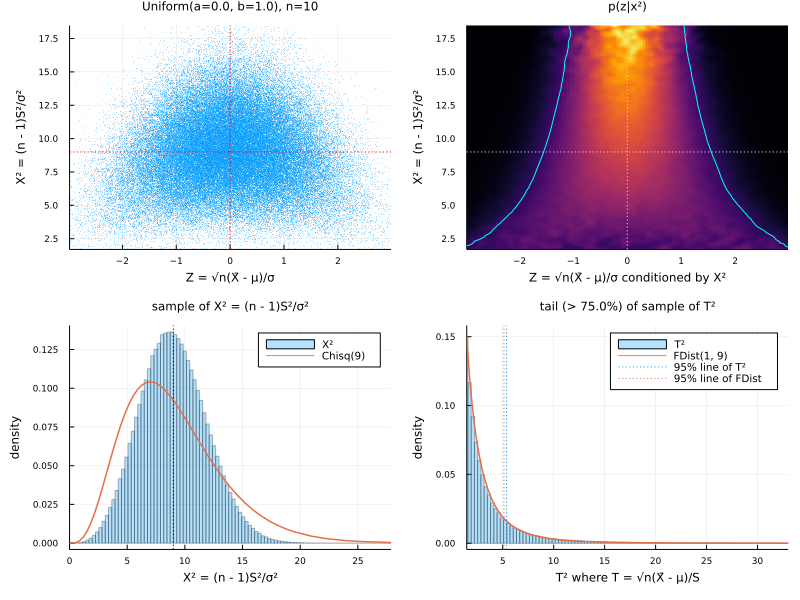

In [5]:
plot_samplestats(dist = Uniform(), n = 10)

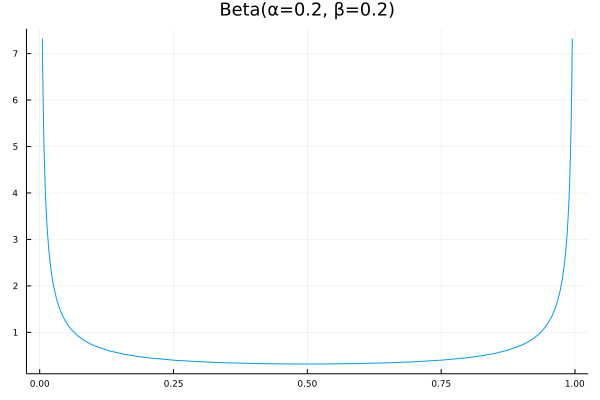

In [6]:
dist = Beta(0.2, 0.2); plot(dist, 0.005, 0.995; label="", title=name(dist), titlefontsize=12)

1000000 samples with size n = 10 of Beta(α=0.2, β=0.2)
skewness, kurtosis = 0.0, -1.7647
√quantile(T², 0.95) = 2.3198,  
P(|T| > √quantile(FDist(1, 9), 0.95) = 2.2622) = 0.054


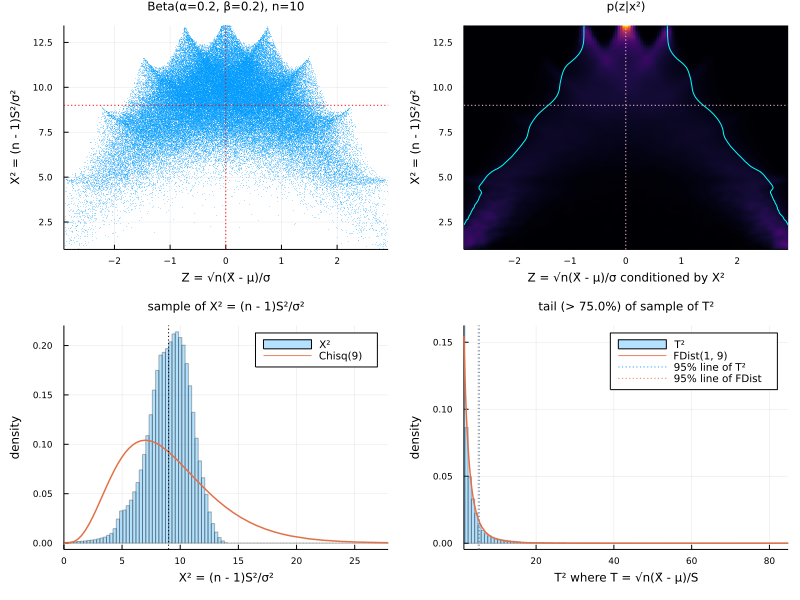

In [7]:
plot_samplestats(dist = Beta(0.2, 0.2), n = 10)

1000000 samples with size n = 20 of Beta(α=0.2, β=0.2)
skewness, kurtosis = 0.0, -1.7647
√quantile(T², 0.95) = 2.116,  
P(|T| > √quantile(FDist(1, 19), 0.95) = 2.093) = 0.052


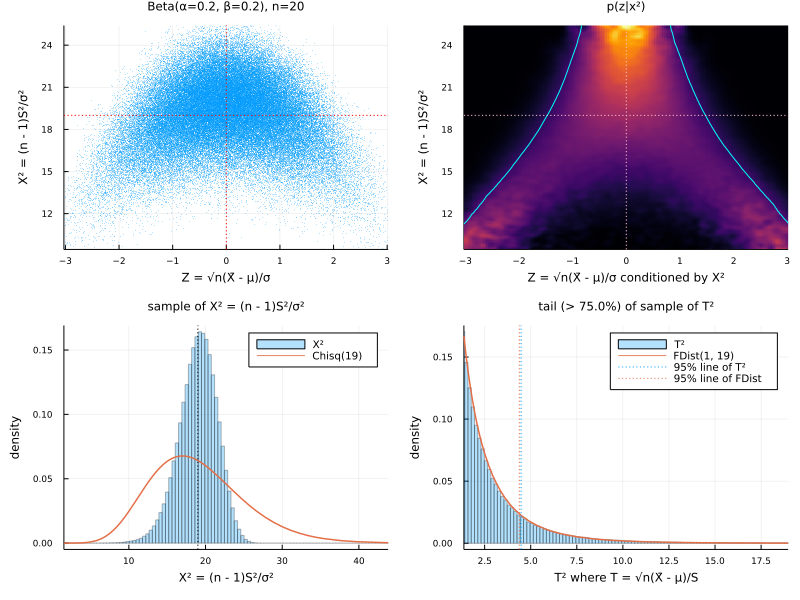

In [8]:
plot_samplestats(dist = Beta(0.2, 0.2), n = 20)

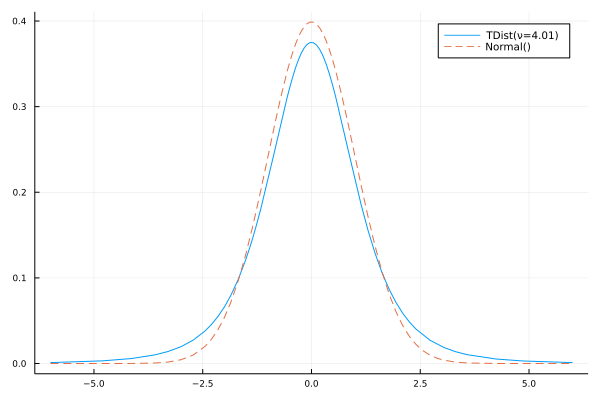

In [9]:
dist = TDist(4.01); plot(dist, -6, 6; label=name(dist))
plot!(Normal(), -6, 6; label="Normal()", ls=:dash)

1000000 samples with size n = 10 of TDist(ν=4.01)
skewness, kurtosis = 0.0, 600.0
√quantile(T², 0.95) = 2.1839,  
P(|T| > √quantile(FDist(1, 9), 0.95) = 2.2622) = 0.0434


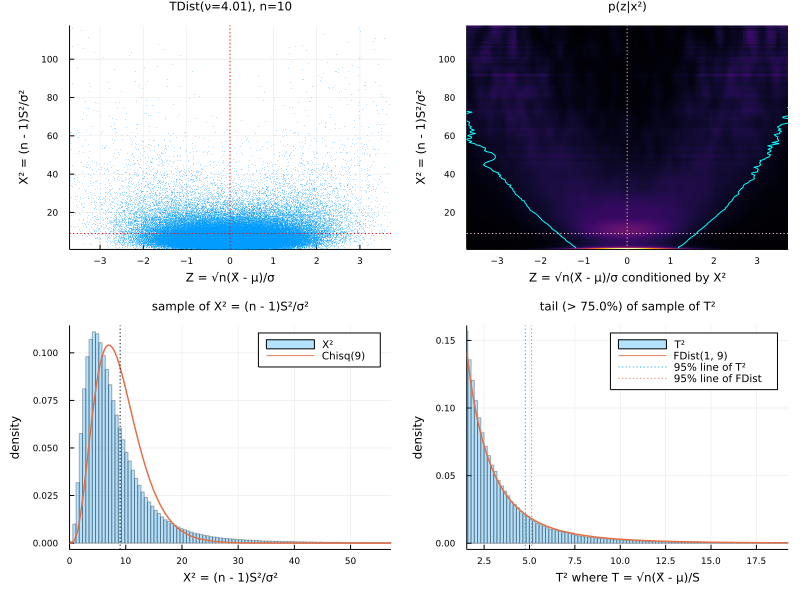

In [10]:
plot_samplestats(dist = TDist(4.01), n = 10)

1000000 samples with size n = 20 of TDist(ν=4.01)
skewness, kurtosis = 0.0, 600.0
√quantile(T², 0.95) = 2.047,  
P(|T| > √quantile(FDist(1, 19), 0.95) = 2.093) = 0.0451


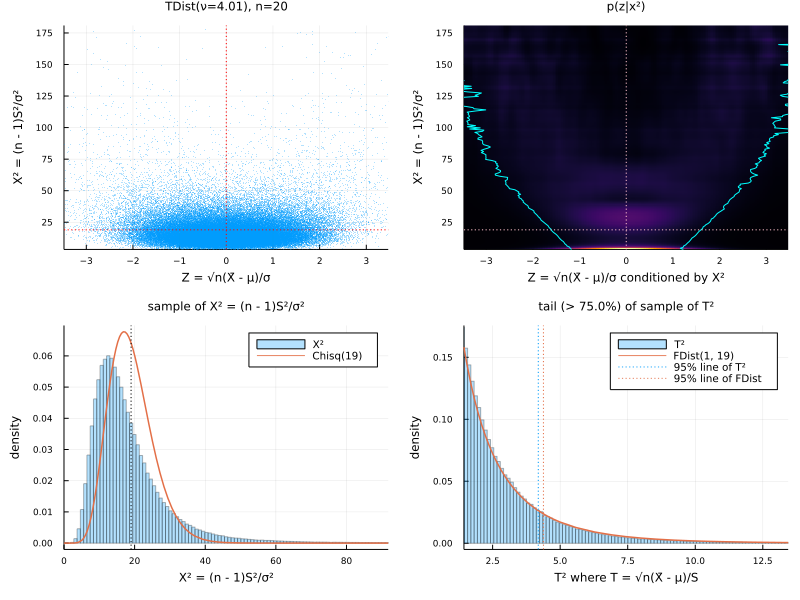

In [11]:
plot_samplestats(dist = TDist(4.01), n = 20)

1000000 samples with size n = 40 of TDist(ν=4.01)
skewness, kurtosis = 0.0, 600.0
√quantile(T², 0.95) = 2.0008,  
P(|T| > √quantile(FDist(1, 39), 0.95) = 2.0227) = 0.0476


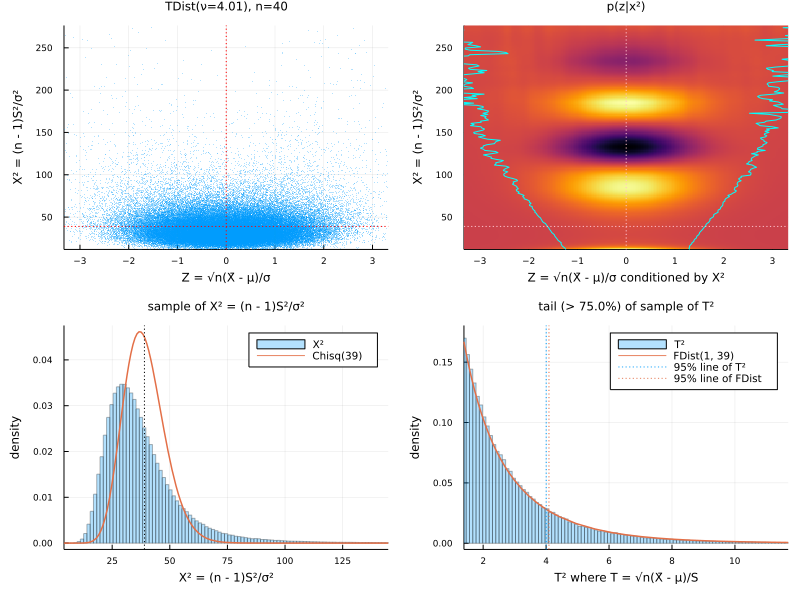

In [12]:
plot_samplestats(dist = TDist(4.01), n = 40)

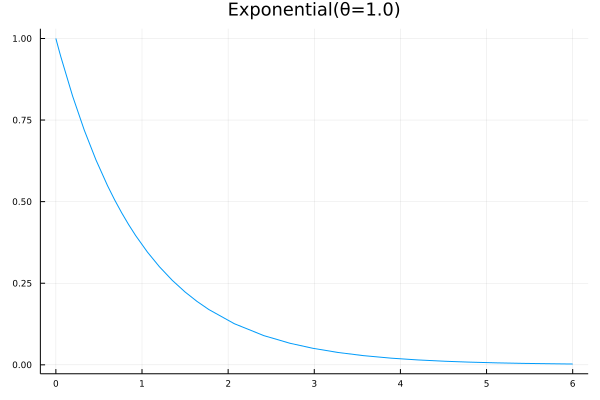

In [13]:
dist = Exponential(); plot(dist, 0, 6; label="", title=name(dist), titlefontsize=12)

1000000 samples with size n = 10 of Exponential(θ=1.0)
skewness, kurtosis = 2.0, 6.0
√quantile(T², 0.95) = 3.1346,  
P(|T| > √quantile(FDist(1, 9), 0.95) = 2.2622) = 0.0994


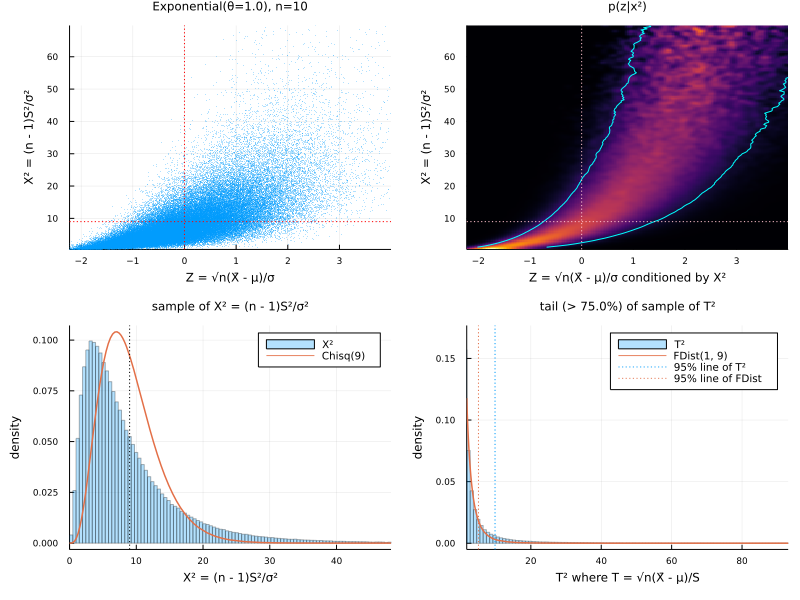

In [14]:
plot_samplestats(dist = Exponential(), n = 10)

1000000 samples with size n = 20 of Exponential(θ=1.0)
skewness, kurtosis = 2.0, 6.0
√quantile(T², 0.95) = 2.5111,  
P(|T| > √quantile(FDist(1, 19), 0.95) = 2.093) = 0.0812


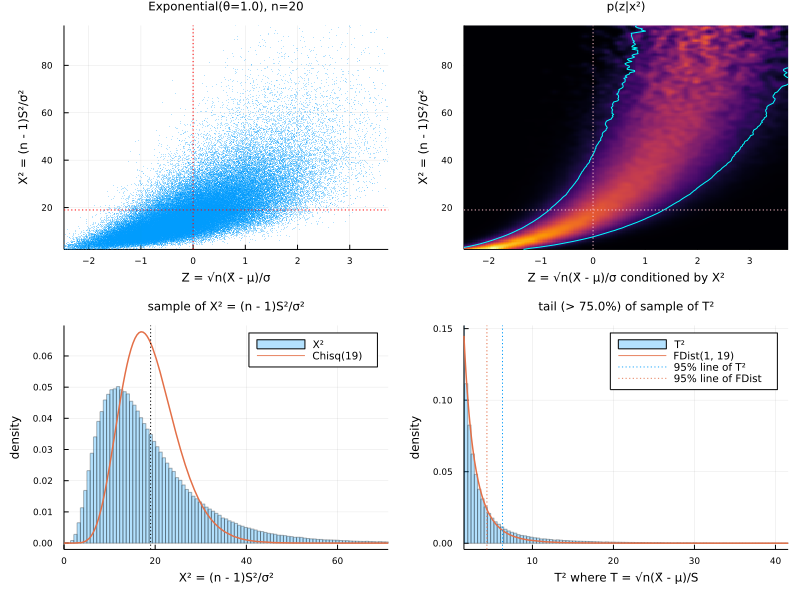

In [15]:
plot_samplestats(dist = Exponential(), n = 20)

1000000 samples with size n = 40 of Exponential(θ=1.0)
skewness, kurtosis = 2.0, 6.0
√quantile(T², 0.95) = 2.2215,  
P(|T| > √quantile(FDist(1, 39), 0.95) = 2.0227) = 0.0677


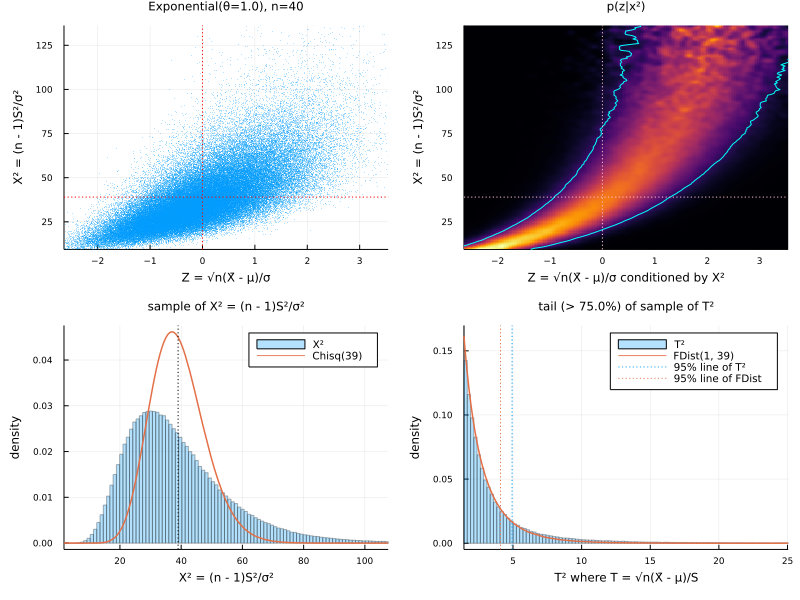

In [16]:
plot_samplestats(dist = Exponential(), n = 40)

1000000 samples with size n = 80 of Exponential(θ=1.0)
skewness, kurtosis = 2.0, 6.0
√quantile(T², 0.95) = 2.0889,  
P(|T| > √quantile(FDist(1, 79), 0.95) = 1.9905) = 0.0599


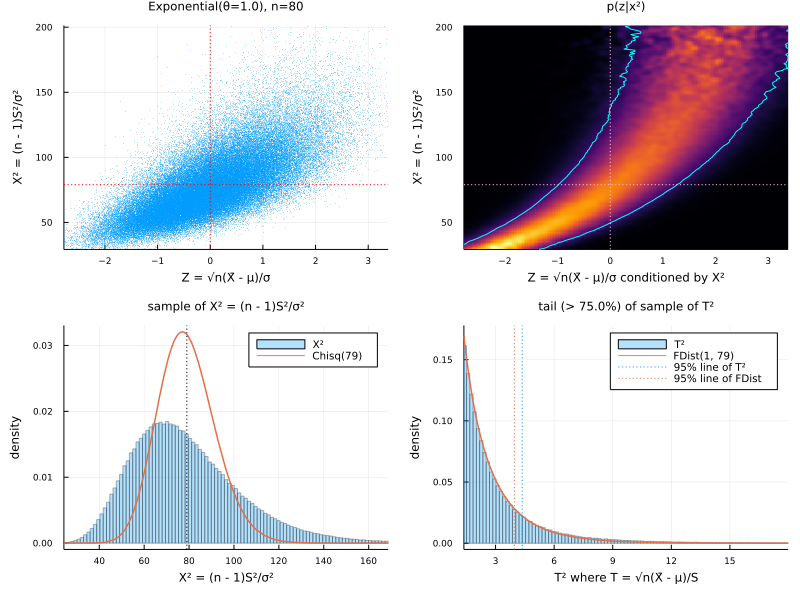

In [17]:
plot_samplestats(dist = Exponential(), n = 80)

1000000 samples with size n = 160 of Exponential(θ=1.0)
skewness, kurtosis = 2.0, 6.0
√quantile(T², 0.95) = 2.0172,  
P(|T| > √quantile(FDist(1, 159), 0.95) = 1.975) = 0.0547


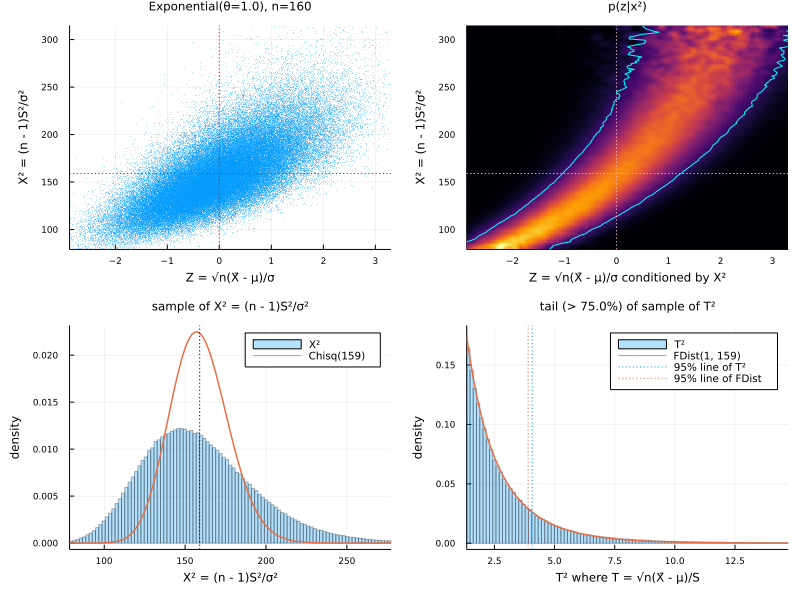

In [18]:
plot_samplestats(dist = Exponential(), n = 160)

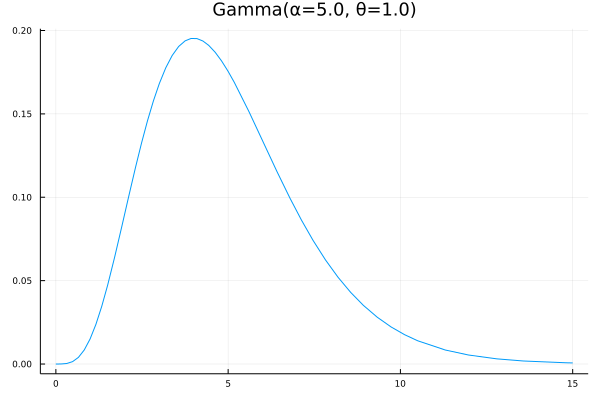

In [19]:
dist = Gamma(5, 1); plot(dist, 0, 15; label="", title=name(dist), titlefontsize=12)

1000000 samples with size n = 10 of Gamma(α=5.0, θ=1.0)
skewness, kurtosis = 0.8944, 1.2
√quantile(T², 0.95) = 2.4089,  
P(|T| > √quantile(FDist(1, 9), 0.95) = 2.2622) = 0.0608


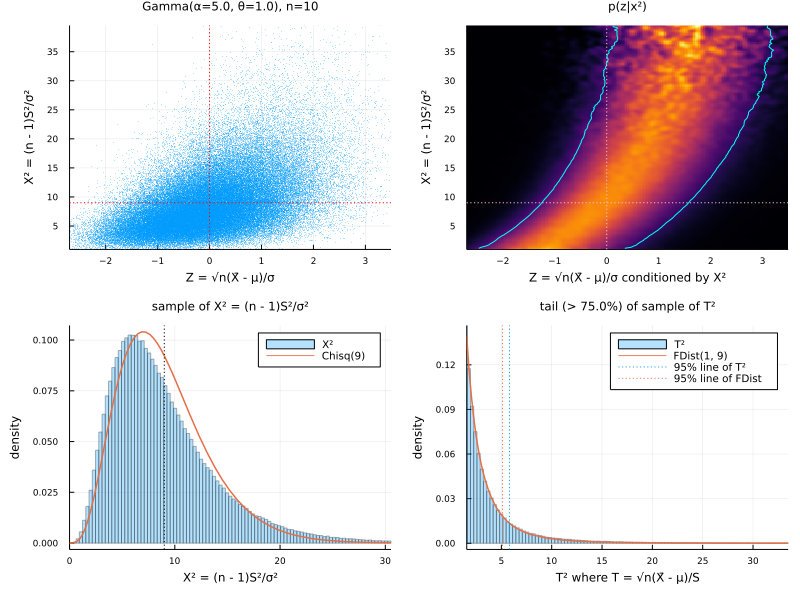

In [20]:
plot_samplestats(dist = Gamma(5, 1), n = 10)

1000000 samples with size n = 20 of Gamma(α=5.0, θ=1.0)
skewness, kurtosis = 0.8944, 1.2
√quantile(T², 0.95) = 2.1655,  
P(|T| > √quantile(FDist(1, 19), 0.95) = 2.093) = 0.0567


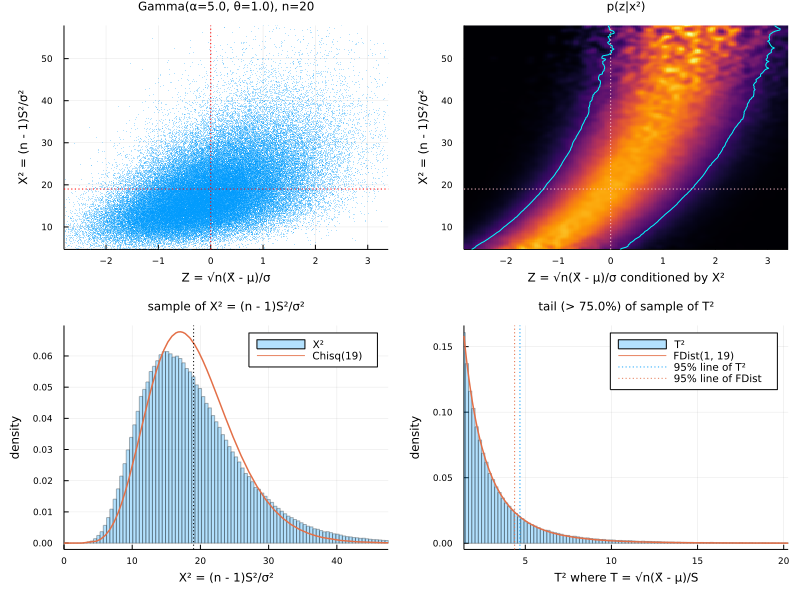

In [21]:
plot_samplestats(dist = Gamma(5, 1), n = 20)

1000000 samples with size n = 40 of Gamma(α=5.0, θ=1.0)
skewness, kurtosis = 0.8944, 1.2
√quantile(T², 0.95) = 2.0596,  
P(|T| > √quantile(FDist(1, 39), 0.95) = 2.0227) = 0.0538


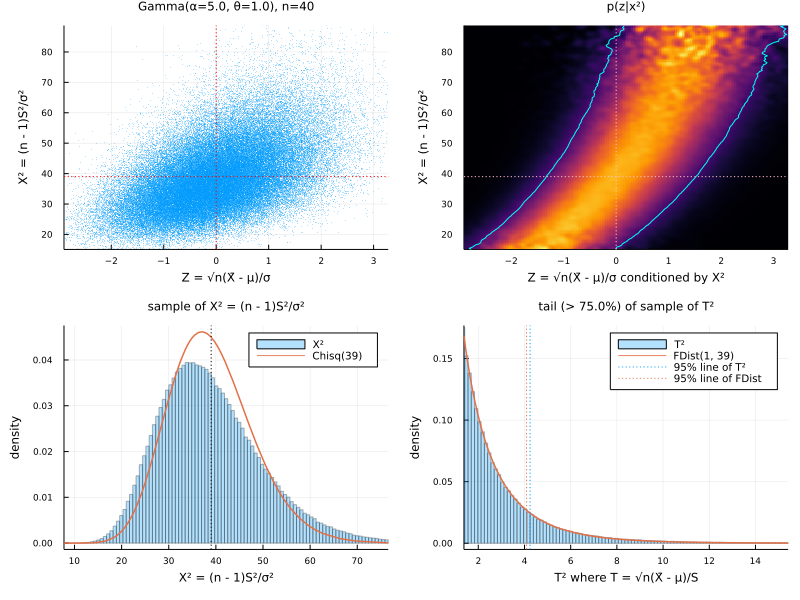

In [22]:
plot_samplestats(dist = Gamma(5, 1), n = 40)

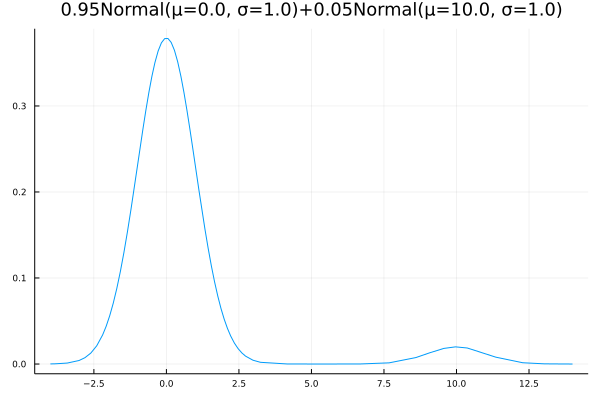

In [23]:
dist = MixtureModel([Normal(), Normal(10,1)], [0.95, 0.05])
plot(dist, -4, 14; label="", title=name(dist), titlefontsize=12)

1000000 samples with size n = 10 of 0.95Normal(μ=0.0, σ=1.0)+0.05Normal(μ=10.0, σ=1.0)
skewness, kurtosis = 3.1005, 10.2722
√quantile(T², 0.95) = 3.4294,  
P(|T| > √quantile(FDist(1, 9), 0.95) = 2.2622) = 0.1754


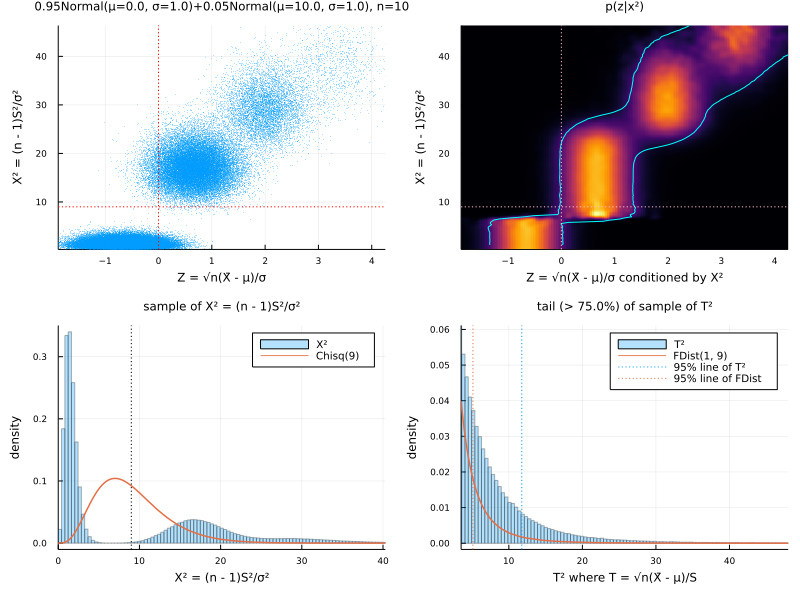

In [24]:
plot_samplestats(dist = MixtureModel([Normal(), Normal(10,1)], [0.95, 0.05]), n = 10)

1000000 samples with size n = 20 of 0.95Normal(μ=0.0, σ=1.0)+0.05Normal(μ=10.0, σ=1.0)
skewness, kurtosis = 3.1005, 10.2722
√quantile(T², 0.95) = 3.5273,  
P(|T| > √quantile(FDist(1, 19), 0.95) = 2.093) = 0.2036


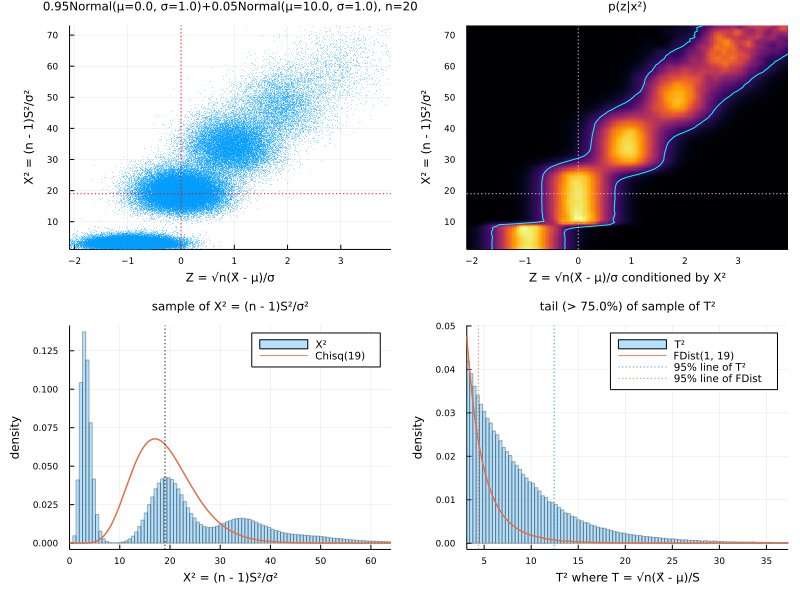

In [25]:
plot_samplestats(dist = MixtureModel([Normal(), Normal(10,1)], [0.95, 0.05]), n = 20)

1000000 samples with size n = 40 of 0.95Normal(μ=0.0, σ=1.0)+0.05Normal(μ=10.0, σ=1.0)
skewness, kurtosis = 3.1005, 10.2722
√quantile(T², 0.95) = 3.4919,  
P(|T| > √quantile(FDist(1, 39), 0.95) = 2.0227) = 0.1199


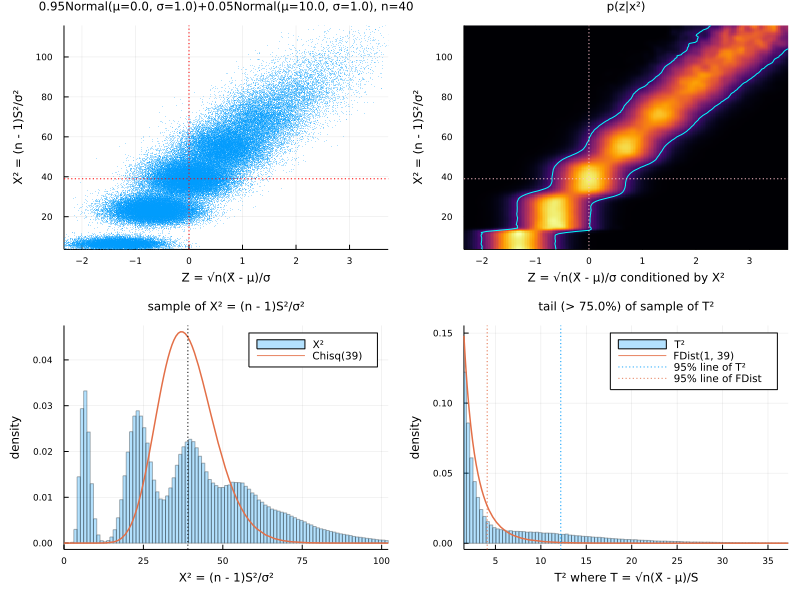

In [26]:
plot_samplestats(dist = MixtureModel([Normal(), Normal(10,1)], [0.95, 0.05]), n = 40)

1000000 samples with size n = 80 of 0.95Normal(μ=0.0, σ=1.0)+0.05Normal(μ=10.0, σ=1.0)
skewness, kurtosis = 3.1005, 10.2722
√quantile(T², 0.95) = 2.3626,  
P(|T| > √quantile(FDist(1, 79), 0.95) = 1.9905) = 0.0792


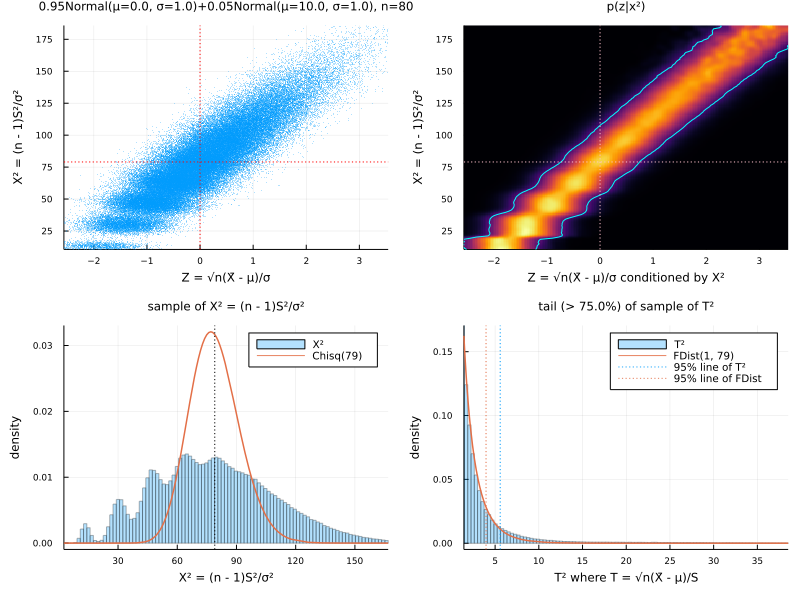

In [27]:
plot_samplestats(dist = MixtureModel([Normal(), Normal(10,1)], [0.95, 0.05]), n = 80)

1000000 samples with size n = 160 of 0.95Normal(μ=0.0, σ=1.0)+0.05Normal(μ=10.0, σ=1.0)
skewness, kurtosis = 3.1005, 10.2722
√quantile(T², 0.95) = 2.1189,  
P(|T| > √quantile(FDist(1, 159), 0.95) = 1.975) = 0.0641


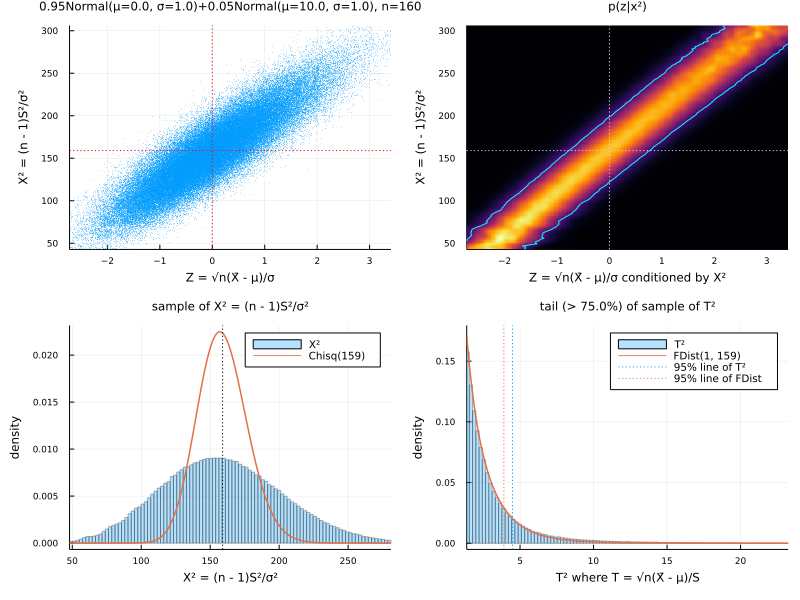

In [28]:
plot_samplestats(dist = MixtureModel([Normal(), Normal(10,1)], [0.95, 0.05]), n = 160)

1000000 samples with size n = 320 of 0.95Normal(μ=0.0, σ=1.0)+0.05Normal(μ=10.0, σ=1.0)
skewness, kurtosis = 3.1005, 10.2722
√quantile(T², 0.95) = 2.0333,  
P(|T| > √quantile(FDist(1, 319), 0.95) = 1.9674) = 0.0571


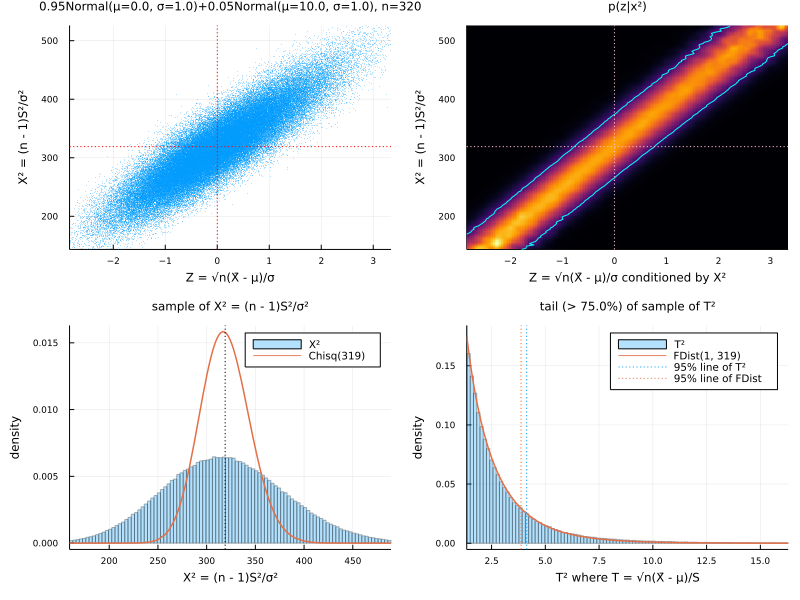

In [29]:
plot_samplestats(dist = MixtureModel([Normal(), Normal(10,1)], [0.95, 0.05]), n = 320)

1000000 samples with size n = 640 of 0.95Normal(μ=0.0, σ=1.0)+0.05Normal(μ=10.0, σ=1.0)
skewness, kurtosis = 3.1005, 10.2722
√quantile(T², 0.95) = 1.9961,  
P(|T| > √quantile(FDist(1, 639), 0.95) = 1.9637) = 0.0536


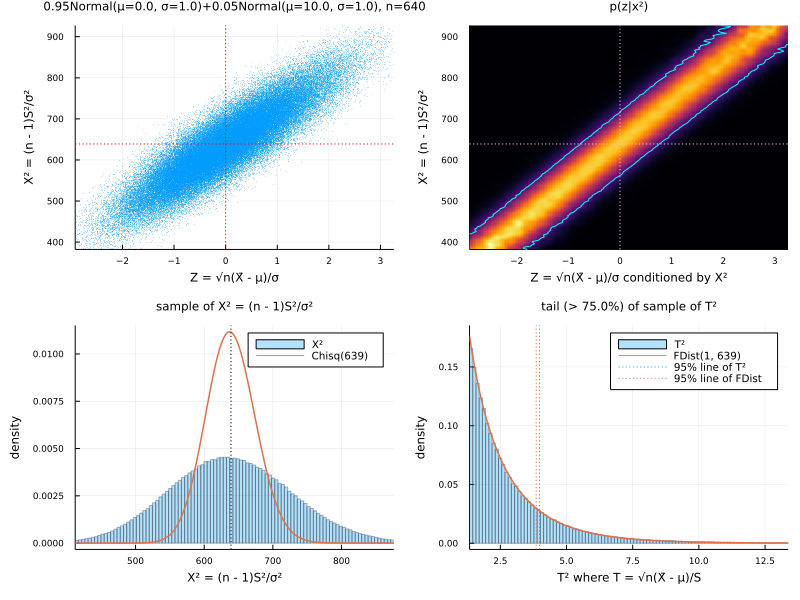

In [30]:
plot_samplestats(dist = MixtureModel([Normal(), Normal(10,1)], [0.95, 0.05]), n = 640)

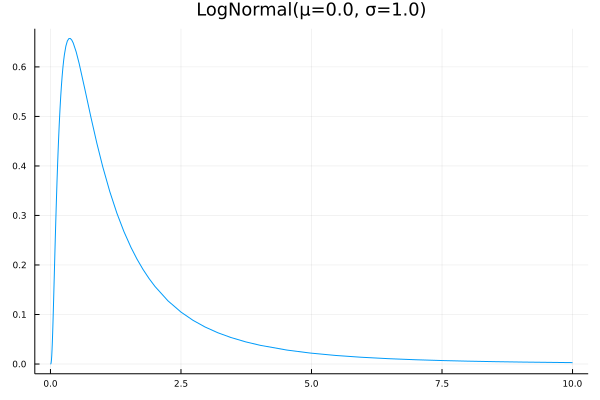

In [31]:
dist = LogNormal()
plot(dist, 0, 10; label="", title=name(dist), titlefontsize=12)

1000000 samples with size n = 10 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 4.3429,  
P(|T| > √quantile(FDist(1, 9), 0.95) = 2.2622) = 0.1609


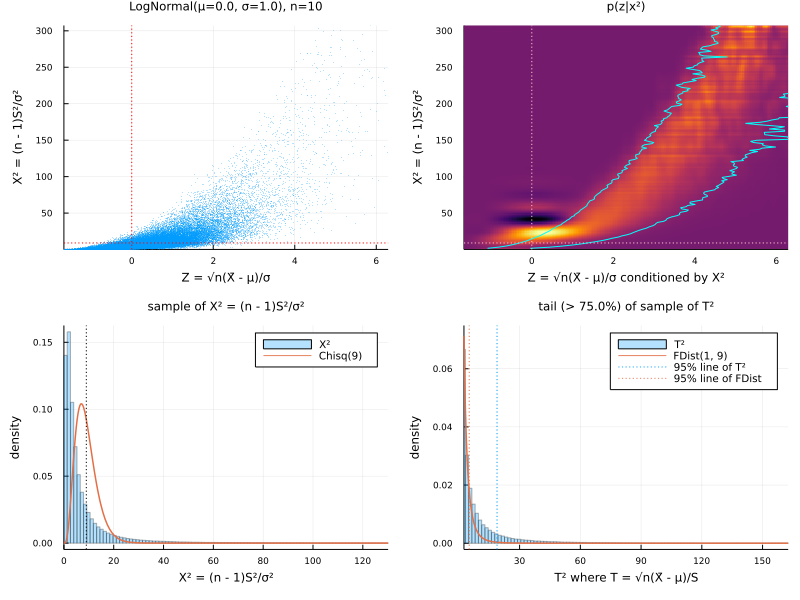

In [32]:
plot_samplestats(dist = LogNormal(), n = 10)

1000000 samples with size n = 20 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 3.3659,  
P(|T| > √quantile(FDist(1, 19), 0.95) = 2.093) = 0.1329


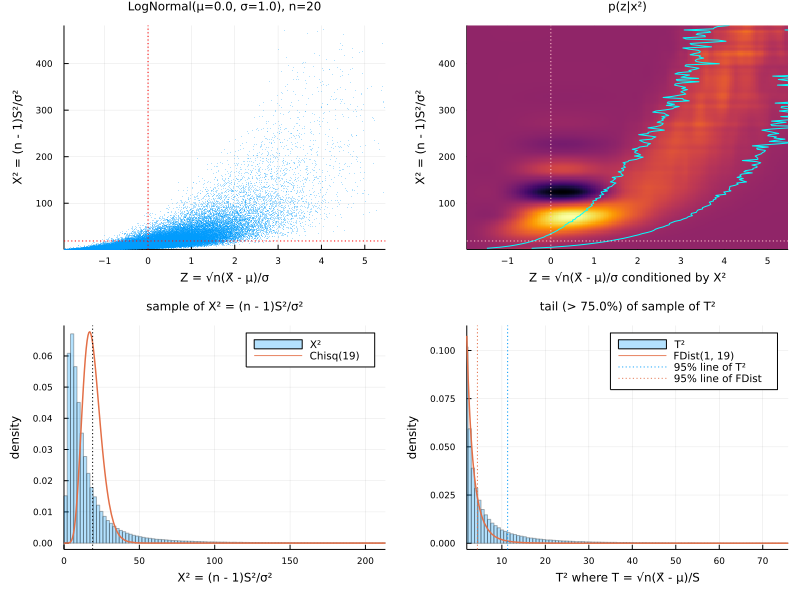

In [33]:
plot_samplestats(dist = LogNormal(), n = 20)

1000000 samples with size n = 40 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 2.8042,  
P(|T| > √quantile(FDist(1, 39), 0.95) = 2.0227) = 0.1078


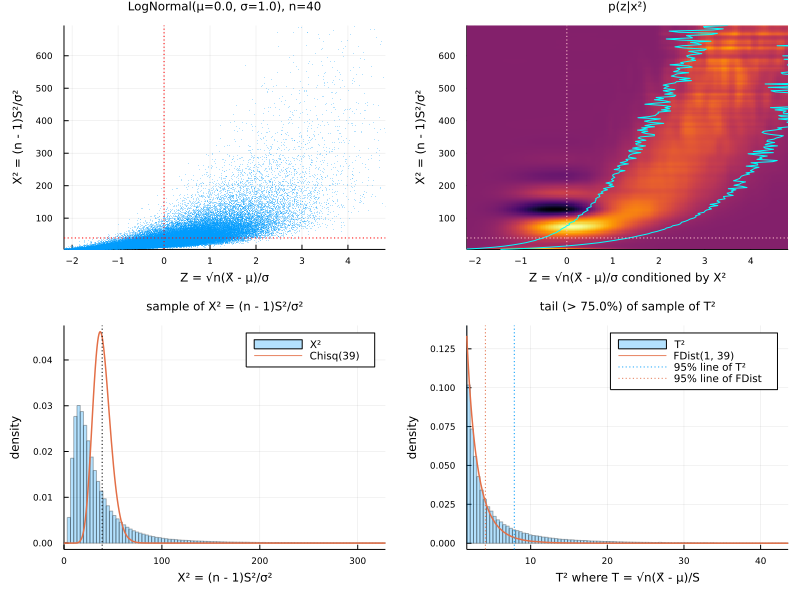

In [34]:
plot_samplestats(dist = LogNormal(), n = 40)

1000000 samples with size n = 80 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 2.4455,  
P(|T| > √quantile(FDist(1, 79), 0.95) = 1.9905) = 0.0878


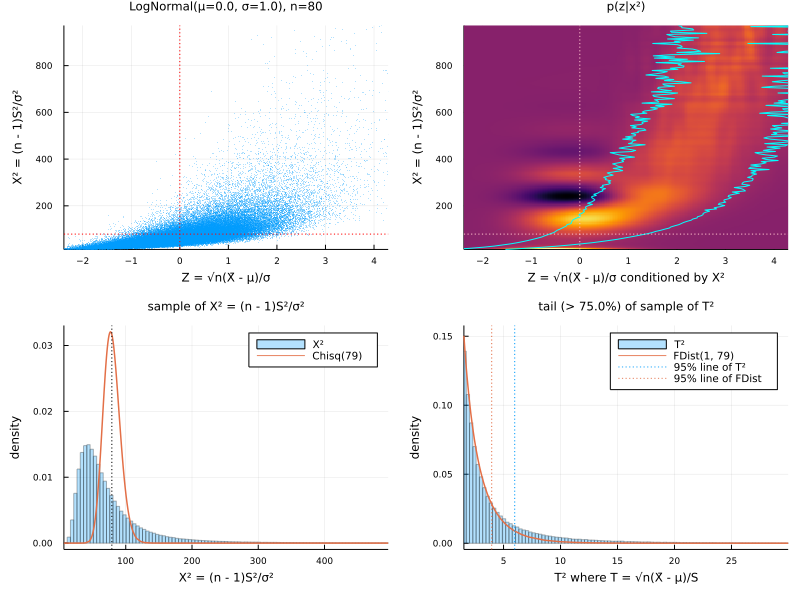

In [35]:
plot_samplestats(dist = LogNormal(), n = 80)

1000000 samples with size n = 160 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 2.2343,  
P(|T| > √quantile(FDist(1, 159), 0.95) = 1.975) = 0.074


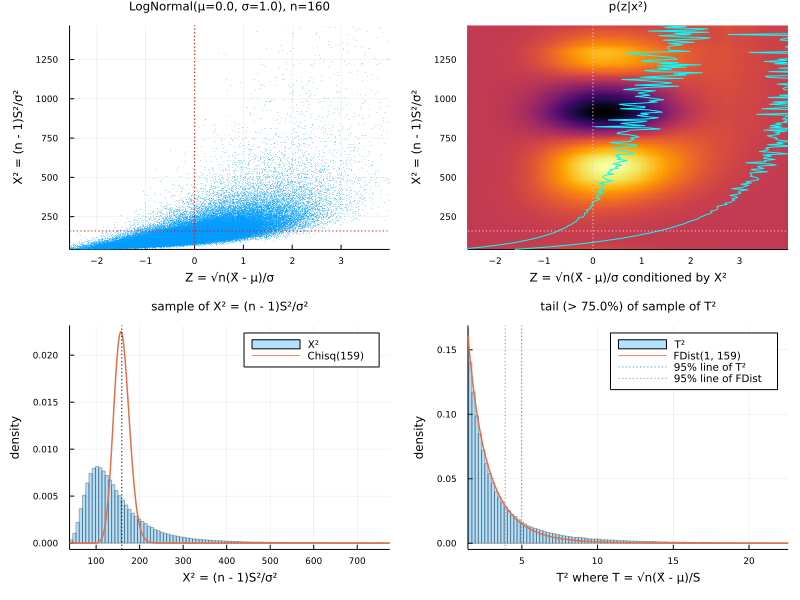

In [36]:
plot_samplestats(dist = LogNormal(), n = 160)

1000000 samples with size n = 320 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 2.1134,  
P(|T| > √quantile(FDist(1, 319), 0.95) = 1.9674) = 0.0645


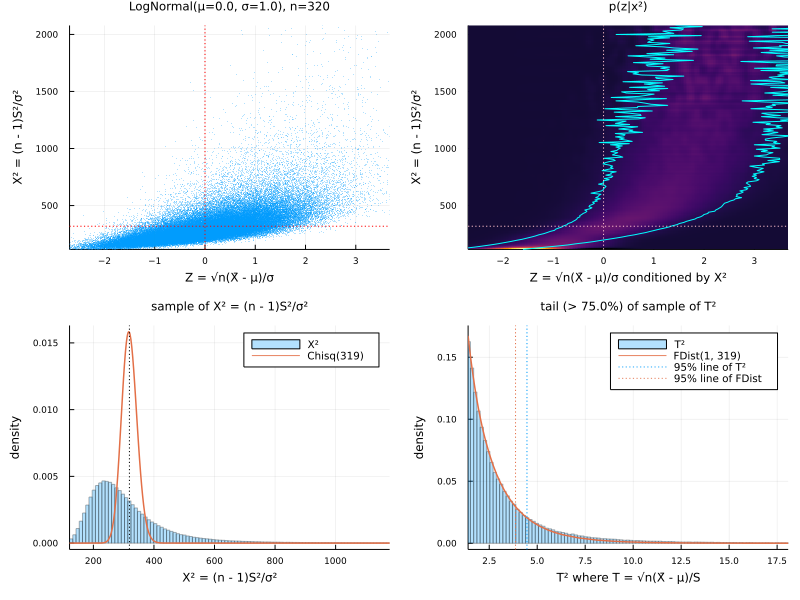

In [37]:
plot_samplestats(dist = LogNormal(), n = 320)

1000000 samples with size n = 640 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 2.0416,  
P(|T| > √quantile(FDist(1, 639), 0.95) = 1.9637) = 0.0584


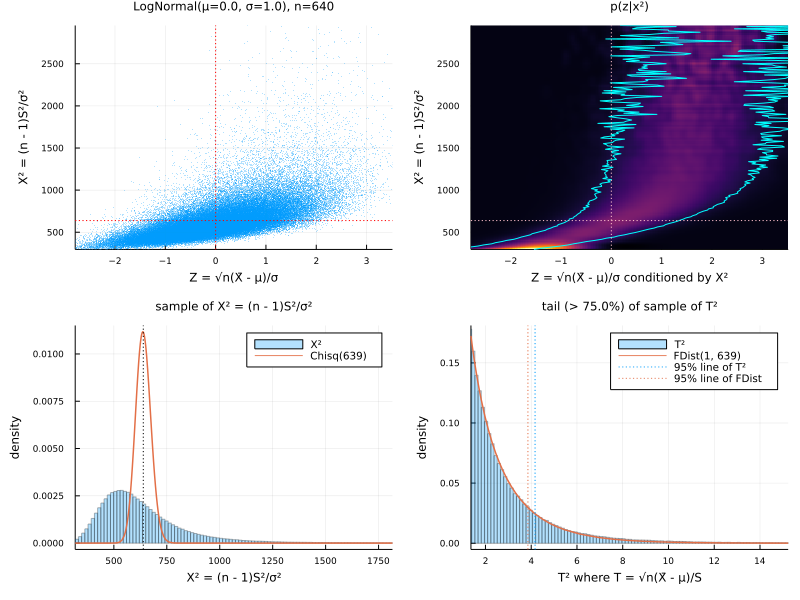

In [38]:
plot_samplestats(dist = LogNormal(), n = 640)

1000000 samples with size n = 1280 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 2.006,  
P(|T| > √quantile(FDist(1, 1279), 0.95) = 1.9618) = 0.0549


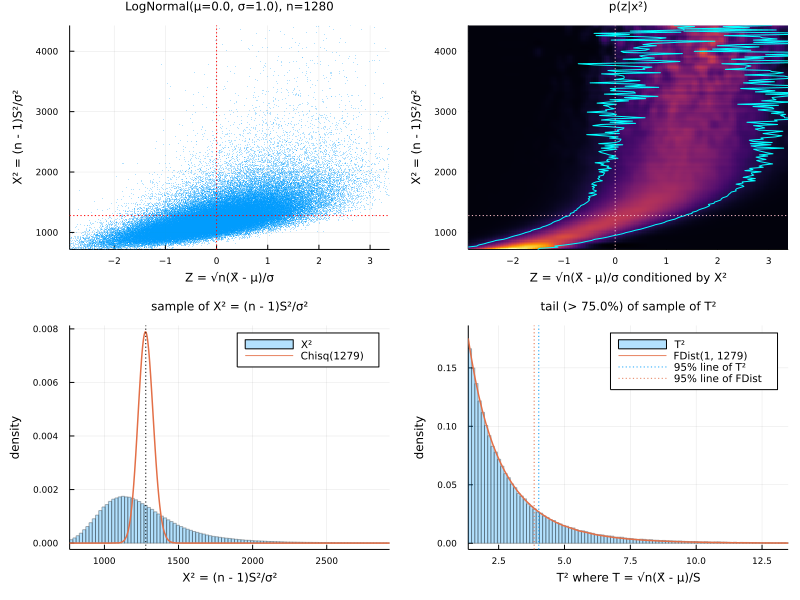

In [39]:
plot_samplestats(dist = LogNormal(), n = 1280)

1000000 samples with size n = 2560 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 1.9805,  
P(|T| > √quantile(FDist(1, 2559), 0.95) = 1.9609) = 0.0522


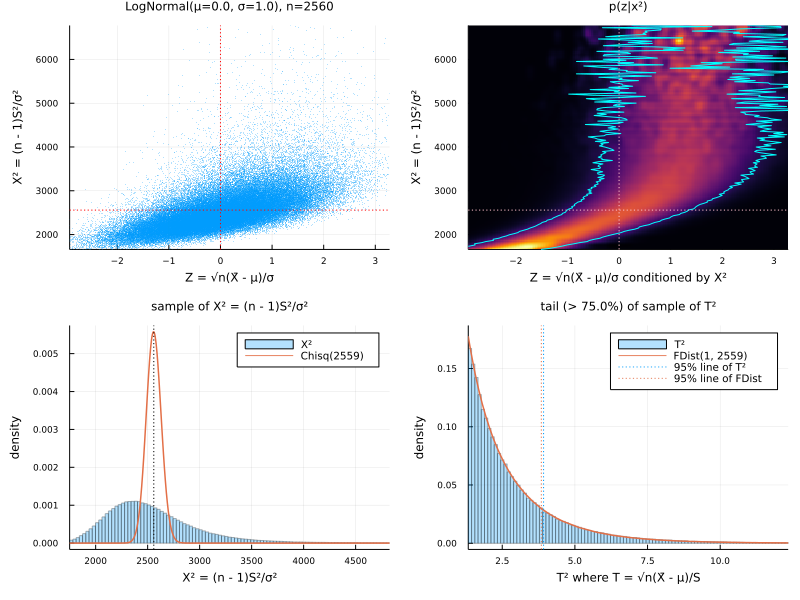

In [40]:
plot_samplestats(dist = LogNormal(), n = 2560)

1000000 samples with size n = 5120 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 1.9733,  
P(|T| > √quantile(FDist(1, 5119), 0.95) = 1.9604) = 0.0514


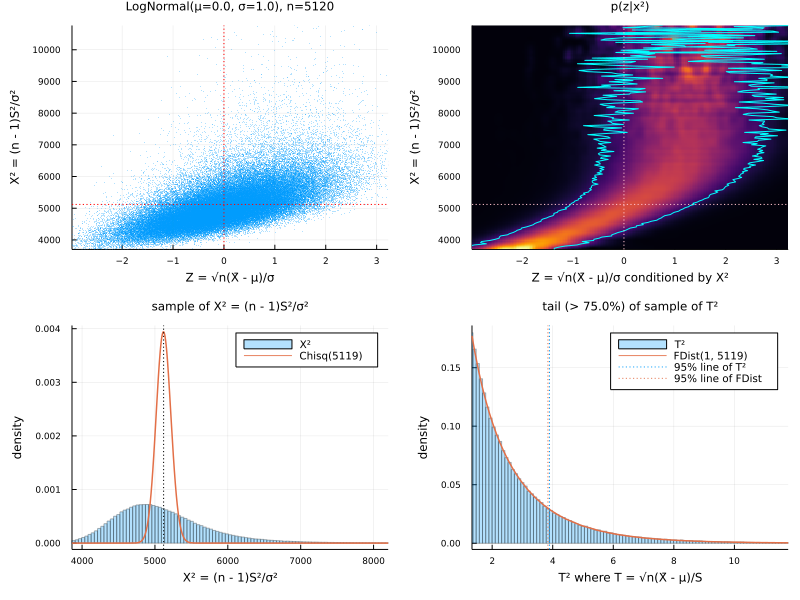

In [41]:
plot_samplestats(dist = LogNormal(), n = 5120)

1000000 samples with size n = 10240 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 1.967,  
P(|T| > √quantile(FDist(1, 10239), 0.95) = 1.9602) = 0.0508


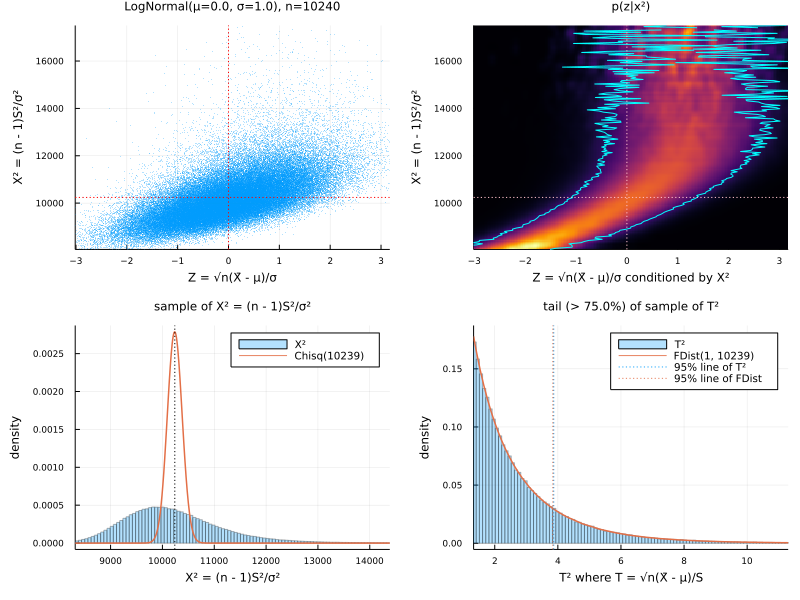

In [42]:
plot_samplestats(dist = LogNormal(), n = 10240)

1000000 samples with size n = 20480 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 1.9633,  
P(|T| > √quantile(FDist(1, 20479), 0.95) = 1.9601) = 0.0504


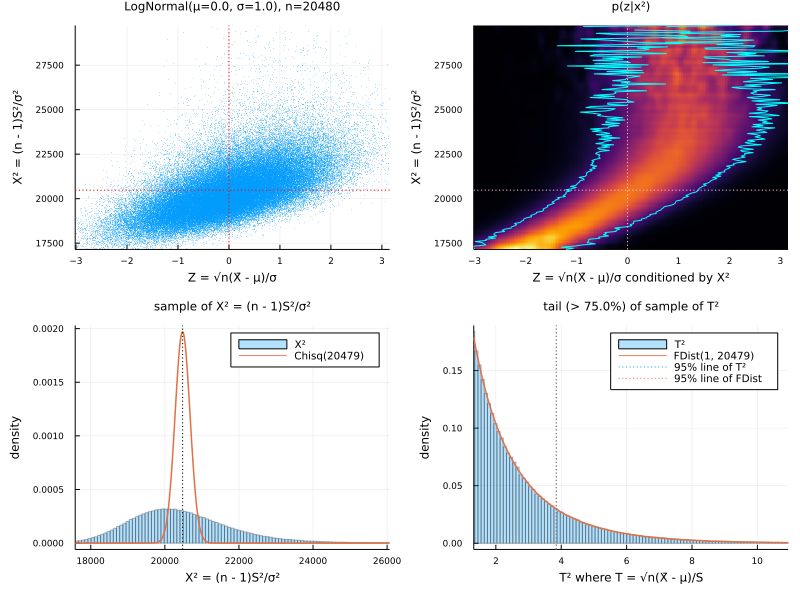

In [43]:
plot_samplestats(dist = LogNormal(), n = 20480)

1000000 samples with size n = 40960 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 1.9583,  
P(|T| > √quantile(FDist(1, 40959), 0.95) = 1.96) = 0.0498


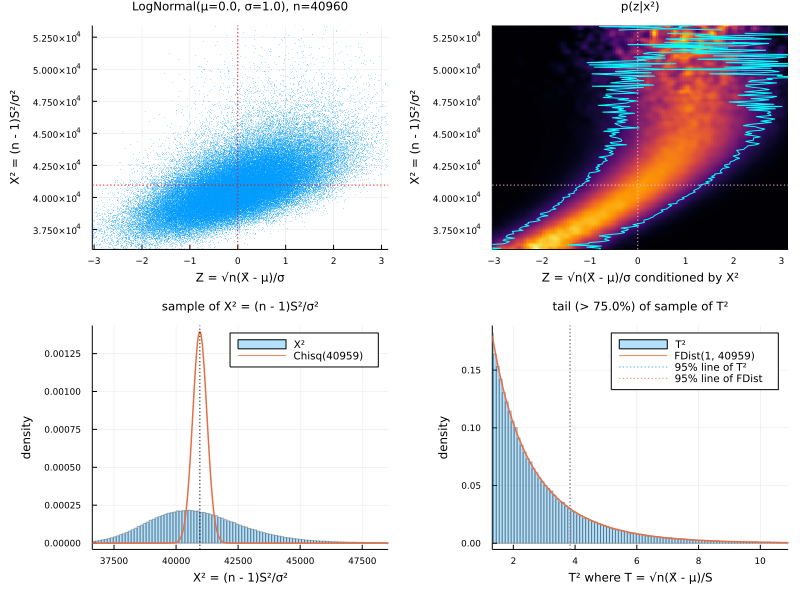

In [44]:
plot_samplestats(dist = LogNormal(), n = 40960)

1000000 samples with size n = 81920 of LogNormal(μ=0.0, σ=1.0)
skewness, kurtosis = 6.1849, 110.9364
√quantile(T², 0.95) = 1.9594,  
P(|T| > √quantile(FDist(1, 81919), 0.95) = 1.96) = 0.0499


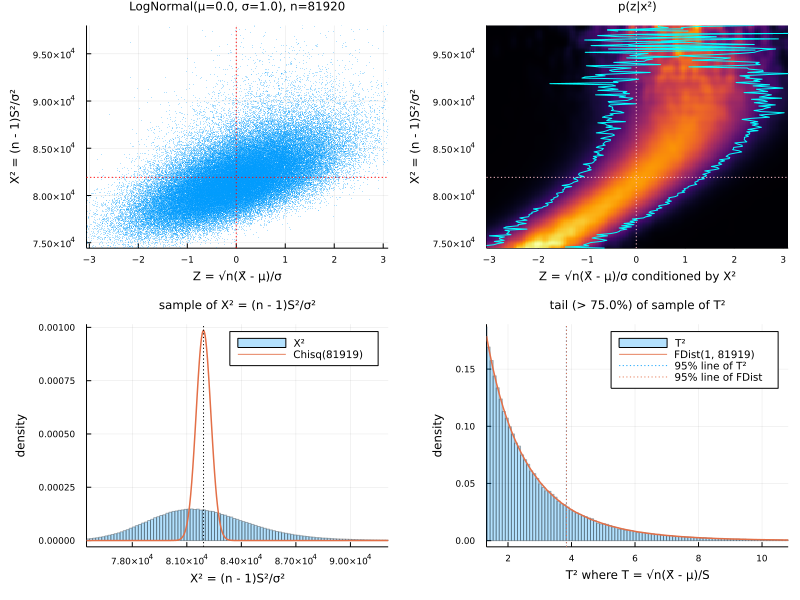

In [45]:
plot_samplestats(dist = LogNormal(), n = 81920)